In [16]:
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# List of experiments, with chunk type, chunk size.
list_chunks = [
('words', 50),
('words', 300),
('words', 500),
('sentences', 10),
('sentences', 50),
('sentences', 100),
('paragraphs', 1),
('paragraphs', 5),
('paragraphs', 10),
('paragraphs', 15),
('pages', 1)
]

In [4]:
k_list = [2, 5, 10, 15]


In [5]:
# loading the metrics from the json files
list_vals = []
for TOP_K in k_list:
    for CHUNK_TYPE, CHUNK_SIZE in list_chunks:
        metrics_filename = f"outputs/metrics_k{TOP_K}_type{CHUNK_TYPE}_size{CHUNK_SIZE}.json"
        #print(metrics_filename)
        metrics = json.load(open(metrics_filename))
        toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE, "negative_rejection": metrics["negative_rejection_percentage"]}

        # For now I'll only load the full dataset metrics, change this if you want to load the other ones.
        dict_metrics = metrics['full_dataset']['full_dataset']
        toAdd |= dict_metrics
        list_vals.append(toAdd)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/metrics_k5_typewords_size500.json'

# For now don't have all vals yet, stick to what we had:

In [6]:
# List of experiments, with k, chunk type, chunk size.
list_exps = [
(2, 'words', 50),
(2, 'words', 300),
(2, 'words', 500),
(5, 'words', 50),
(5, 'words', 300),
(10, 'words', 50),
(10, 'words', 300),
(2, 'sentences', 10),
(2, 'sentences', 50),
(2, 'sentences', 100),
(5, 'sentences', 10),
(10, 'sentences', 10),
(2, 'paragraphs', 1),
(2, 'paragraphs', 5),
(2, 'paragraphs', 10),
(2, 'paragraphs', 15),
(5, 'paragraphs', 1),
(5, 'paragraphs', 5),
(5, 'paragraphs', 10),
(10, 'paragraphs', 1),
(10, 'paragraphs', 5),
(1, 'pages', 1),
(2, 'pages', 1)
]

In [7]:
# loading the metrics from the json files
list_vals = []
for TOP_K, CHUNK_TYPE, CHUNK_SIZE in list_exps:
    metrics_filename = f"outputs/metrics_k{TOP_K}_type{CHUNK_TYPE}_size{CHUNK_SIZE}.json"
    #print(metrics_filename)
    metrics = json.load(open(metrics_filename))
    toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE, "negative_rejection": metrics["negative_rejection_percentage"]}

    # For now I'll only load the full dataset metrics, change this if you want to load the other ones.
    dict_metrics = metrics['full_dataset']['full_dataset']
    toAdd |= dict_metrics
    list_vals.append(toAdd)

In [8]:
df = pd.DataFrame(list_vals)

In [9]:
df.head()

,k,chunk_type,chunk_size,negative_rejection,answer_relevancy,faithfulness,context_recall,context_precision,answer_correctness,EM,F1,avg_retrieve_context,avg_llm_response,avg_total,sample_size
0,2,words,50,90.0,0.605545,0.765455,0.714318,0.763636,0.603506,0.054545,0.404558,0.058654,1.102986,1.161640,110
1,2,words,300,80.0,0.672901,0.830411,0.807576,0.759091,0.655461,0.072727,0.453499,0.058809,1.230641,1.289450,110
2,2,words,500,90.0,0.649961,0.784545,0.850000,0.813636,0.643772,0.090909,0.472971,0.063309,1.113785,1.177094,110
3,5,words,50,100.0,0.658820,0.824562,0.816970,0.731414,0.617743,0.063636,0.458147,0.070781,1.336184,1.406965,110
4,5,words,300,80.0,0.708026,0.801487,0.926515,0.743333,0.681700,0.063636,0.493760,0.068165,1.254819,1.322983,110


Code for getting bubble heatmap:
1. get the data read in for each rfp type + k, chunk_type, chunk_size, etc
2. calc std
3. add that to the df
4. get bubble heatmap


In [10]:
test = json.load(open("outputs/metrics_k2_typepages_size1.json"))

In [11]:
# loading the metrics from the json files
list_vals = []
for TOP_K, CHUNK_TYPE, CHUNK_SIZE in list_exps:
    metrics_filename = f"outputs/metrics_k{TOP_K}_type{CHUNK_TYPE}_size{CHUNK_SIZE}.json"
    #print(metrics_filename)
    metrics = json.load(open(metrics_filename))
    #toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE, "negative_rejection": metrics["negative_rejection_percentage"]}

    # For now I'll only load the full dataset metrics, change this if you want to load the other ones.
    rfps = metrics['RFP_id']
    for rfp in rfps.keys():
        toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE, "rfp_id": rfp}
        dict_metrics = rfps[rfp]
        toAdd |= dict_metrics
        list_vals.append(toAdd)
df_rfp = pd.DataFrame(list_vals)

In [12]:
list_metrics = ["answer_relevancy","faithfulness", 'context_recall','context_precision', 
                'answer_correctness', 'EM', 'F1',
                'avg_retrieve_context', 'avg_llm_response', 'avg_total', 'sample_size']

df_grouped = df_rfp.groupby(['k', 'chunk_type', 'chunk_size']).apply(lambda x: x[list_metrics].std()).reset_index()
df_final = pd.merge(df, df_grouped, on = ['k', 'chunk_type', 'chunk_size'], how='left', suffixes=('', '_std'))

/var/folders/_y/nvmjy5xs14b01kr1kt942tc80000gn/T/ipykernel_49804/2623827307.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df_rfp.groupby(['k', 'chunk_type', 'chunk_size']).apply(lambda x: x[list_metrics].std()).reset_index()


In [13]:
# testing here
metric = "answer_relevancy"
metric_std = metric + "_std"
toPlot = df_final[["k", "chunk_type", "chunk_size", metric, metric_std]]
#sns.heatmap(toPlot.pivot(index=["chunk_type", "chunk_size"], columns="k", values=metric), cmap = "crest", annot = True).set_title(metric + " by chunks")

In [14]:
toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)

/var/folders/_y/nvmjy5xs14b01kr1kt942tc80000gn/T/ipykernel_49804/3300174220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


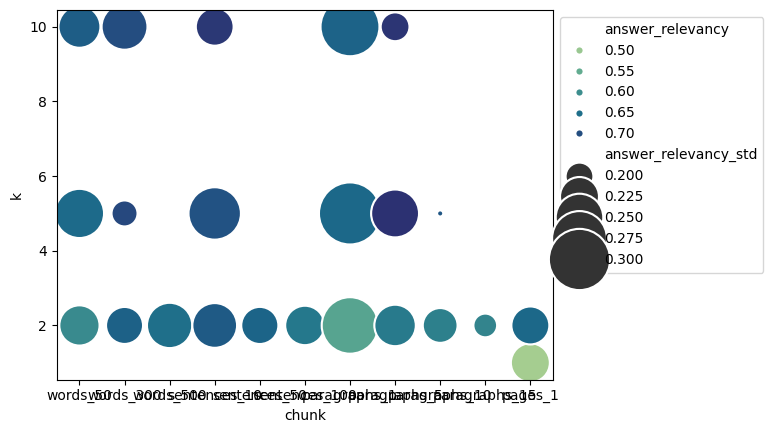

In [17]:
ax = sns.scatterplot(
    data=toPlot,
    x="chunk",
    y="k",
    size="answer_relevancy_std",
    hue = "answer_relevancy",
    sizes=(20, 2000),
    palette = "crest"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# show the graph
plt.show()

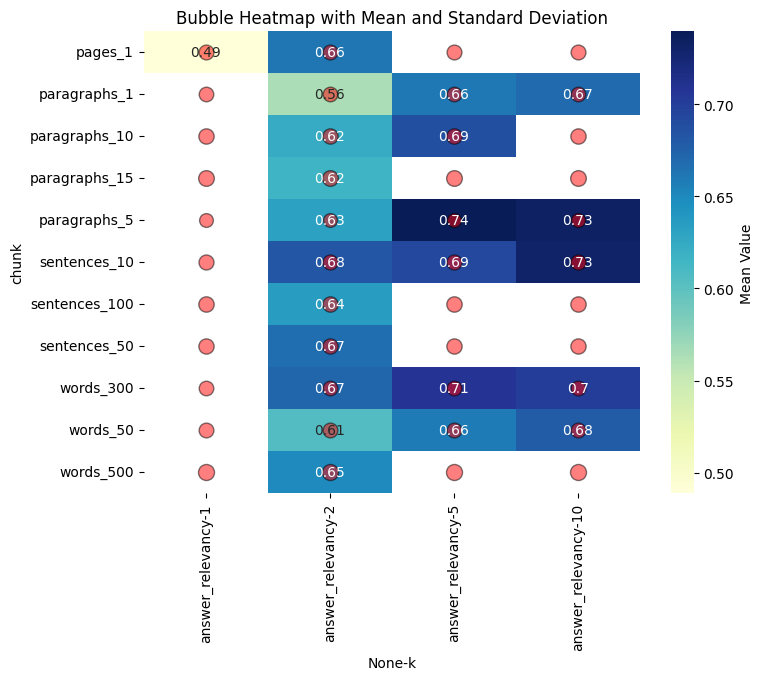

In [23]:
# Plot the heatmap for mean values
plt.figure(figsize=(8, 6))
ax = sns.heatmap(toPlot.pivot(index=["chunk"], columns="k", values=[metric]), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Value'})

# Overlay bubbles based on standard deviation values (size of bubbles)
for i in range(toPlot[metric].shape[0]):
    for j in range(toPlot["chunk"].shape[0]):
        # You can adjust the bubble size based on the standard deviation value
        ax.scatter(j + 0.5, i + 0.5, s=toPlot[metric_std].iloc[i] * 500, c='red', alpha=0.5, edgecolors='black')

plt.title('Bubble Heatmap with Mean and Standard Deviation')
plt.show()


# Older stuff

In [16]:
def single_type_heatmap(df, chunk_type = "words", metric = "faithfulness"):
    """Pass in chunk_type and metric as strings from the dataframe columns."""
    toPlot = df[df.chunk_type==chunk_type][["k", "chunk_size", metric]]
    sns.heatmap(toPlot.pivot(index="k", columns="chunk_size", values=metric), cmap = "crest", annot = True).set_title("Chunk by "+chunk_type)

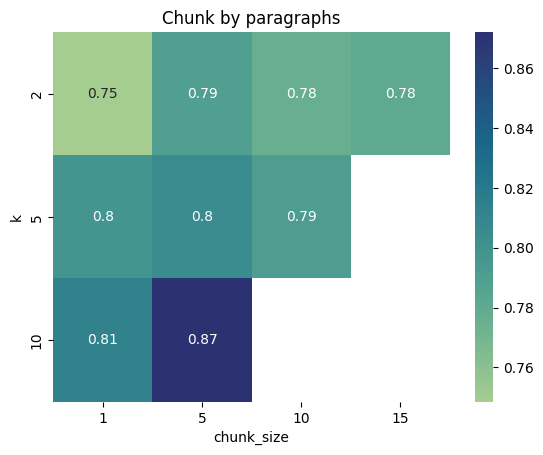

In [17]:
single_type_heatmap(df, "paragraphs", "faithfulness")


In [18]:
def all_chunks_heatmap(df, metric = "faithfulness"):
    toPlot = df[["k", "chunk_type", "chunk_size", metric]]
    sns.heatmap(toPlot.pivot(index=["chunk_type", "chunk_size"], columns="k", values=metric), cmap = "crest", annot = True).set_title(metric + " by chunks")

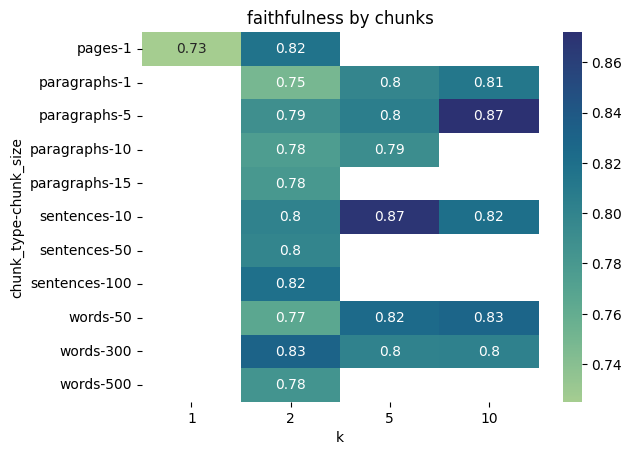

In [19]:
all_chunks_heatmap(df, "faithfulness")

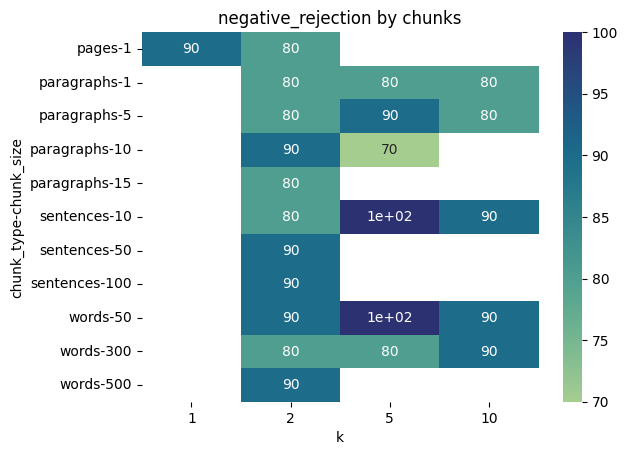

In [20]:
all_chunks_heatmap(df, "negative_rejection")

wait what happened to words-50? The drop off from k =5 to 10 is kinda weird, checking the exp_output file seems correct though, might need to check/rerun?

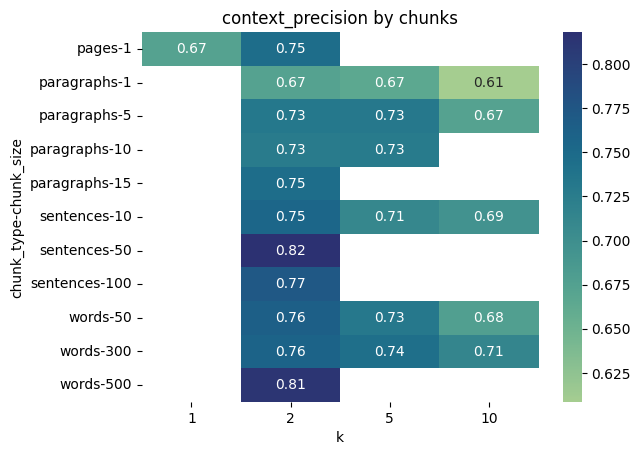

In [72]:
all_chunks_heatmap(df, "context_precision")

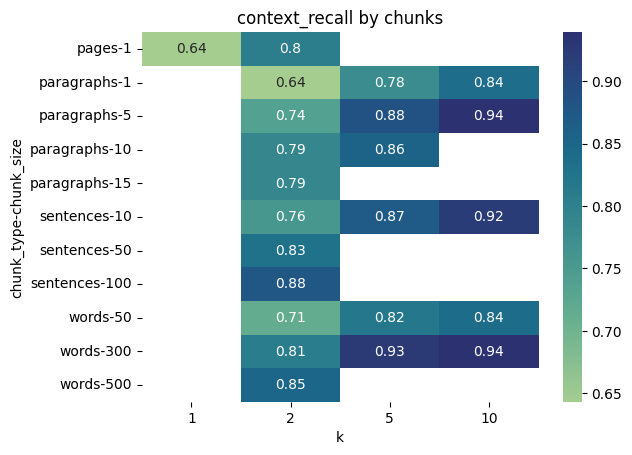

In [73]:
all_chunks_heatmap(df, "context_recall")

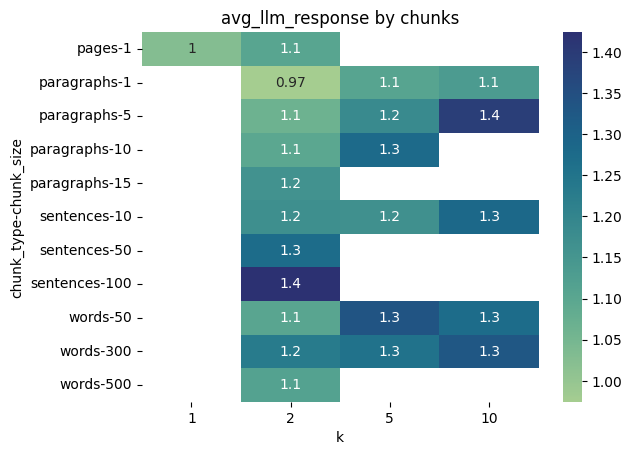

In [76]:
all_chunks_heatmap(df, "avg_llm_response")

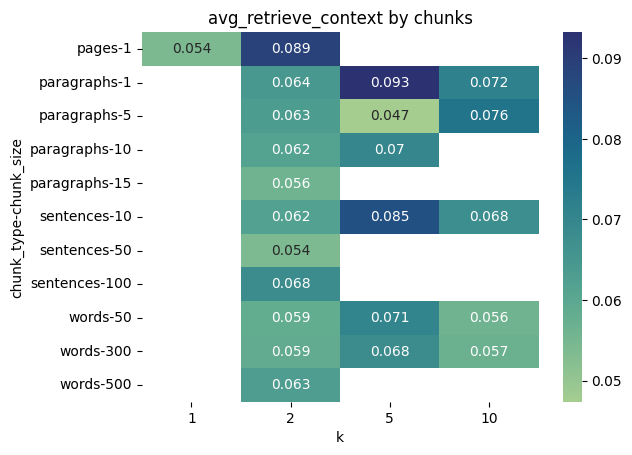

In [77]:
all_chunks_heatmap(df, "avg_retrieve_context")

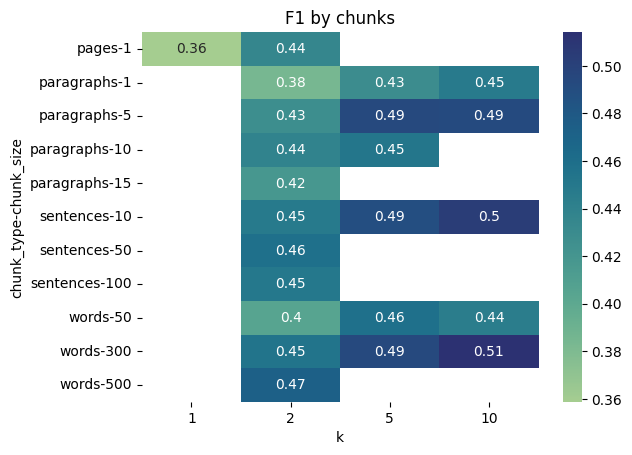

In [80]:
all_chunks_heatmap(df, "F1")

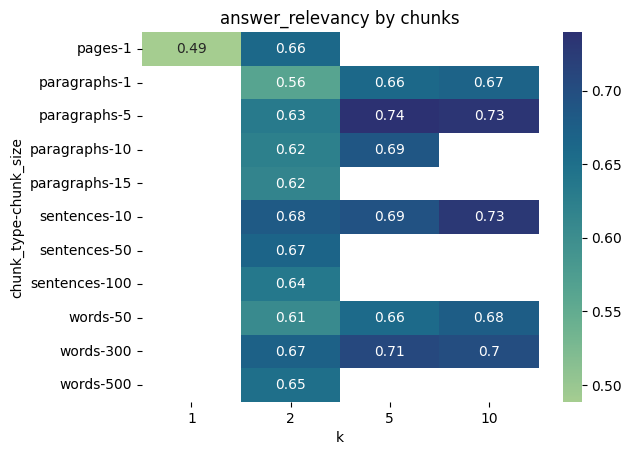

In [81]:
all_chunks_heatmap(df, "answer_relevancy")

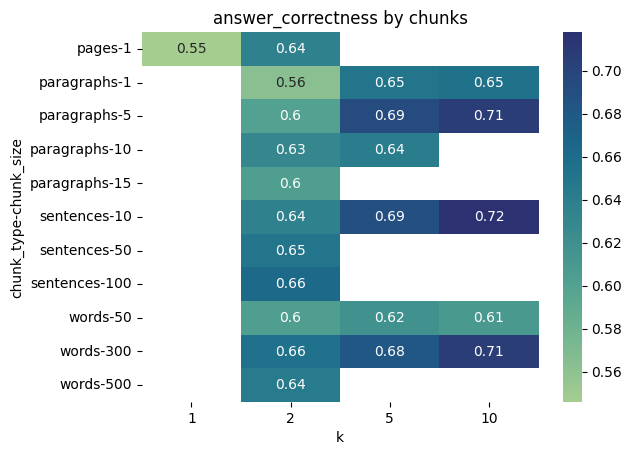

In [82]:
all_chunks_heatmap(df, "answer_correctness")